In [1]:
import pandas as pd
import math
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from MEBF import MEBF, matrix_subtract, matrix_product
import seaborn as sns
import time
from scipy import stats
%matplotlib inline
from numba import jit
import warnings

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True,formatter={'float_kind':'{:.6f}'.format})

In [3]:
data = pd.read_csv("../data/gse.csv",index_col = 0)

# Boolean Matrix Factorization

In [4]:
x_in_paper = pd.DataFrame(np.array([[1,1,0,1,1,1,0,1,0,0,0],[1,1,1,1,1,1,1,1,1,1,1],[1,1,0,1,1,1,1,0,1,0,1],
         [0,1,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,0,1,0,0],
         [0,0,0,1,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,0],[1,1,0,1,0,1,1,0,0,0,0],
         [1,1,1,1,1,0,0,0,0,0,0,],[1,1,0,1,1,0,0,0,0,0,0]]), index = range(1,12), columns = range(1,12))
A,B = MEBF(x_in_paper,0.8)

<AxesSubplot:>

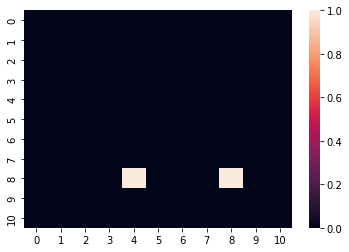

In [5]:
sns.heatmap(matrix_subtract(x_in_paper.values, matrix_product(A.values, B.values)), annot=False, vmin=0, vmax=1)

# BCV

### set iteration = 30

In [4]:
@jit
def bcv(data,times=20, num_comps=20, r=5, s=5):
    """
    parameter:
        data: 
            scaled input
            dropped rows and cols with all 0's
        times:
            iteration number of each number of components
        num_compons:
            total number of components
        r:
            the first shape of leave-out submatrix
        s:
            the second shape of leave-out submatrix
    
    function:
        leave out a submatrix A of shape (r,s)
        perform pca with number of components from [1, num_comps] with iteration equal to times
        perform bcv to compute A', and its error
    
    return:
        error, under components and iterations
        1-q2_A, the variance of 1 - var(A-A')/var(A), indicates how good A could be predicted      
    """
    x = data.copy()
    error = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    var_A = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    # iterate over number of components
    for num in range(1,num_comps+1):
        for time in range(1,times+1):
            # shuffle x
            x = x[np.random.permutation(x.columns)]
            x = x.reindex(np.random.permutation(x.index))
            # leave out submatrix
            A = x.values[:r,:s]
            B = x.values[:r,s:]
            C = x.values[r:,:s]
            D = x.values[r:,s:]
            # perform PCA
            pca = PCA(n_components = num)
            pca.fit(D)
            pca_df = pca.transform(D)
            D_approx = pca.inverse_transform(pca_df)
            A_approx = np.dot( np.dot(B,np.linalg.pinv(D_approx)), C)
            residule = A_approx - A
            """
            if (sum(np.abs(residule)).sum() > 10000):
                error.loc[time][num] = 500
            else: 
                error.loc[time][num] = sum(np.abs(residule)).sum()
            """
            error.loc[time][num] = sum(np.abs(residule)).sum()
            var_A.loc[time][num] = np.var(residule) / np.var(A)
    q2_A = pd.DataFrame(np.array(np.mean(var_A)).reshape(1,-1),columns = var_A.columns)
    q2_A = 1 - q2_A
    q2_A[q2_A < 0] = 0
    return error,  q2_A

## Test without log2 transformation

In [5]:
# preprocess on data
# first, drop rows and cols with all 0s
pre = data.copy()
# pre = pre.loc[(pre!=0).any(axis=1)]
# pre = pre.loc[:,(pre!= 0).any(axis=0)]

In [6]:
# choose rows and columns with least 0's
pre[pre!=0] = 1
idx = pre.eq(1).sum(axis=1).sort_values(ascending=False).index
pre = pre.reindex(idx)
cols = pre.eq(1).sum(axis=0).sort_values(ascending=False).index
pre = pre[cols]

In [7]:
# choose 1000 x 1000 left-upper corner submatrix
gse = pd.DataFrame(scale(data,axis=1), index = data.index, columns = data.columns)
gse = gse[pre.columns[0:1000]]
gse = gse.loc[pre.index[0:1000]]

In [8]:
times = 30
num_comps = 30
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse,times,num_comps,10,10)

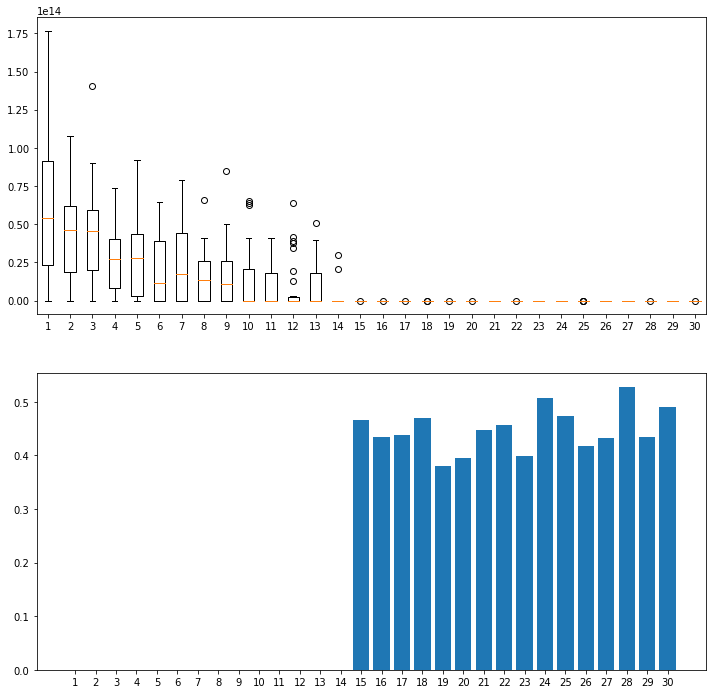

In [9]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [10]:
times = 30
num_comps = 30
error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
#error_t,  q2_A = bcv(gse,times,num_comps,10,10)

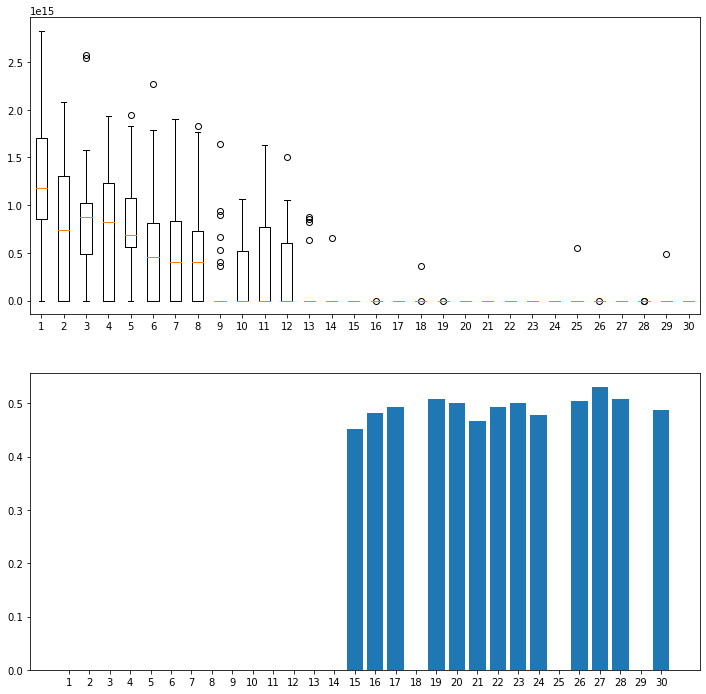

In [11]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

# Check what pca could tell us without log2 transformation

In [12]:
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_15 = pca.inverse_transform(pca_df)
residule_15 = gse - approx_15
# pca checks result
pca = PCA(n_components = 26)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_26 = pca.inverse_transform(pca_df)
residule_26 = gse - approx_26
# pca checks result
pca = PCA(n_components = 5)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_5 = pca.inverse_transform(pca_df)
residule_5 = gse - approx_5

In [15]:
m_15 = approx_15.mean().mean()
s_15 = approx_15.std().std()
m_26 = approx_26.mean().mean()
s_26 = approx_26.std().std()
m_5 = approx_5.mean().mean()
s_5 = approx_5.std().std()
m = gse.mean().mean()
s = gse.std().std()

Text(0.5, 1.0, 'GSE')

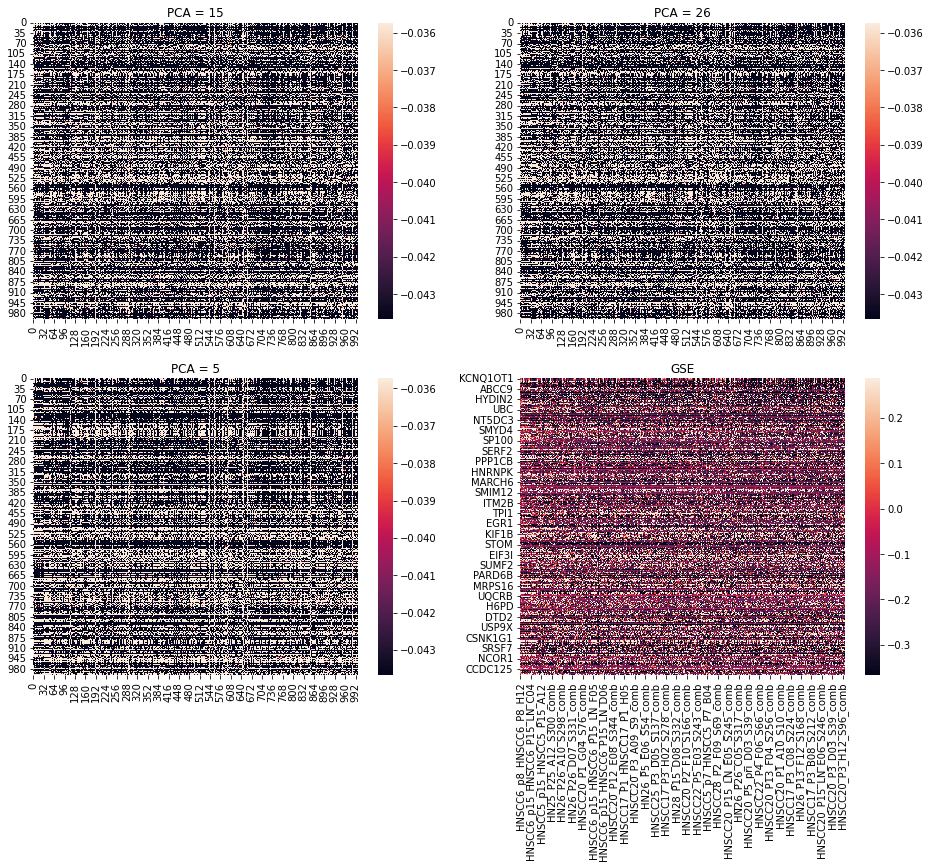

In [21]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
sns.heatmap(approx_15, vmin=m_15-3*s_15, vmax=m_15+3*s_15);
plt.title("PCA = 15")
plt.subplot(2,2,2)
sns.heatmap(approx_26, vmin=m_26-3*s_26, vmax=m_26+3*s_26);
plt.title("PCA = 26")
plt.subplot(2,2,3)
sns.heatmap(approx_5, vmin=m_5-3*s_5, vmax=m_5+3*s_5);
plt.title("PCA = 5")
plt.subplot(2,2,4)
sns.heatmap(gse, vmin=m-3*s, vmax=m+3*s);
plt.title("GSE")

# Try log2 preprocess

In [22]:
tmp = np.log2(data+1).values
scale(tmp, axis=1, copy=False)
# choose 1000 x 1000 left-upper corner submatrix
gse = pd.DataFrame(tmp, index = data.index, columns = data.columns)
gse = gse[pre.columns[0:1000]]
gse = gse.loc[pre.index[0:1000]]

In [23]:
times = 30
num_comps = 30
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse,times,num_comps,10,10)

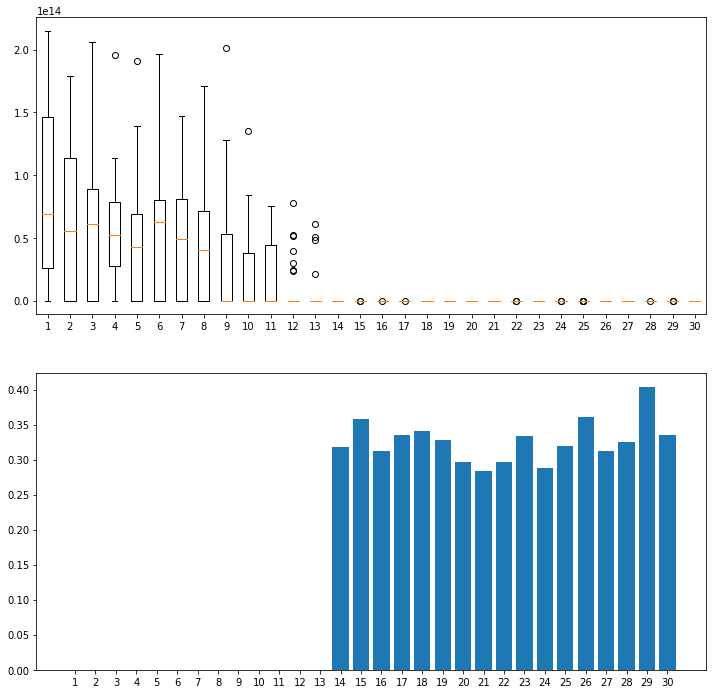

In [24]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [25]:
times = 30
num_comps = 30
error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
#error_t,  q2_A = bcv(gse,times,num_comps,10,10)

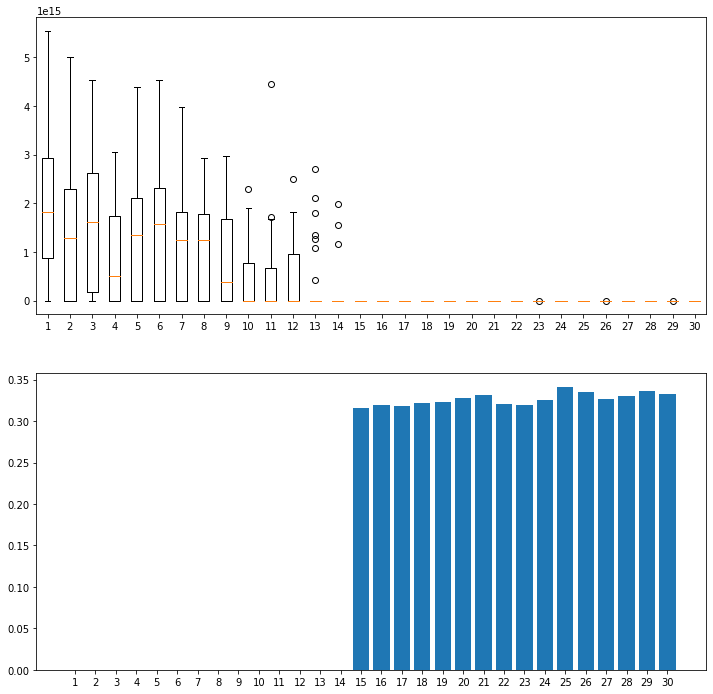

In [26]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

# Check what pca could tell us under log2 transformation

In [28]:
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_15 = pca.inverse_transform(pca_df)
residule_15 = gse - approx_15
# pca checks result
pca = PCA(n_components = 26)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_26 = pca.inverse_transform(pca_df)
residule_26 = gse - approx_26
# pca checks result
pca = PCA(n_components = 5)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_5 = pca.inverse_transform(pca_df)
residule_5 = gse - approx_5

In [29]:
m_15 = approx_15.mean().mean()
s_15 = approx_15.std().std()
m_26 = approx_26.mean().mean()
s_26 = approx_26.std().std()
m_5 = approx_5.mean().mean()
s_5 = approx_5.std().std()
m = gse.mean().mean()
s = gse.std().std()

Text(0.5, 1.0, 'GSE')

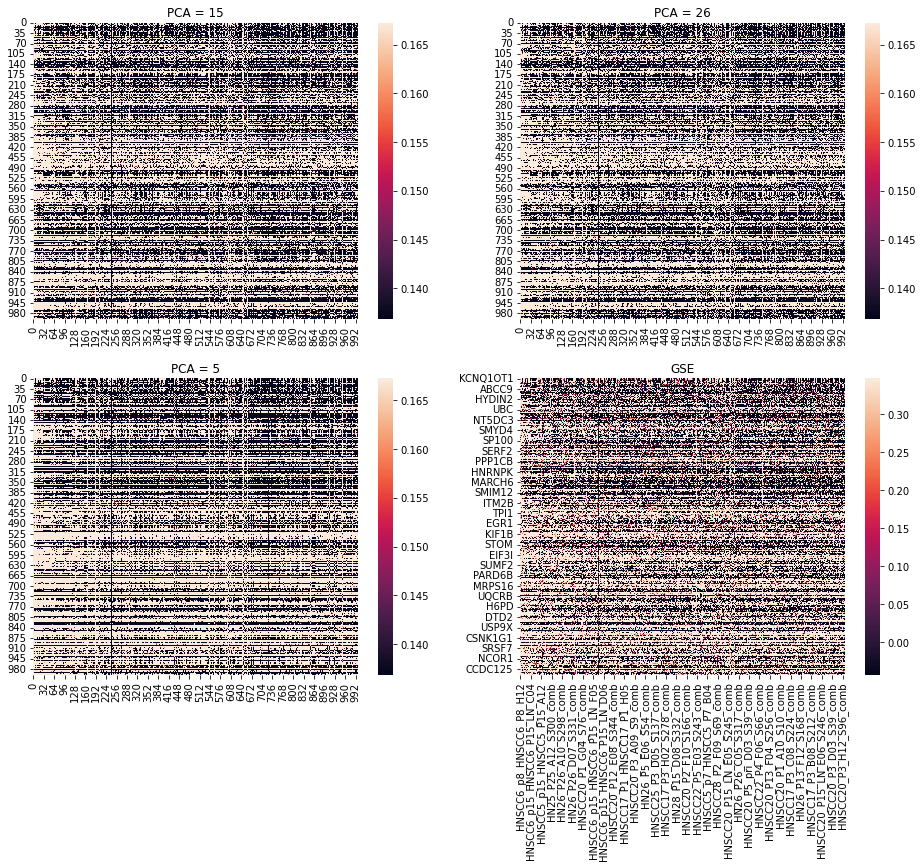

In [30]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
sns.heatmap(approx_15, vmin=m_15-3*s_15, vmax=m_15+3*s_15);
plt.title("PCA = 15")
plt.subplot(2,2,2)
sns.heatmap(approx_26, vmin=m_26-3*s_26, vmax=m_26+3*s_26);
plt.title("PCA = 26")
plt.subplot(2,2,3)
sns.heatmap(approx_5, vmin=m_5-3*s_5, vmax=m_5+3*s_5);
plt.title("PCA = 5")
plt.subplot(2,2,4)
sns.heatmap(gse, vmin=m-3*s, vmax=m+3*s);
plt.title("GSE")

# GSE under log2 transformation in the following tests

# Add a pattern to the matrix, Normal Distribution

In [31]:
gaussian = np.random.normal(4,3.5,size=(100,100))
attach = pd.DataFrame(np.pad(gaussian,((0,900),(0,900)),'constant',constant_values = (0,0)), index = gse.index, columns = gse.columns)
gse_v2 = gse + attach

In [32]:
times = 30
num_comps = 30
error_t,  q2_A = bcv(gse_v2,times,num_comps,10,10)

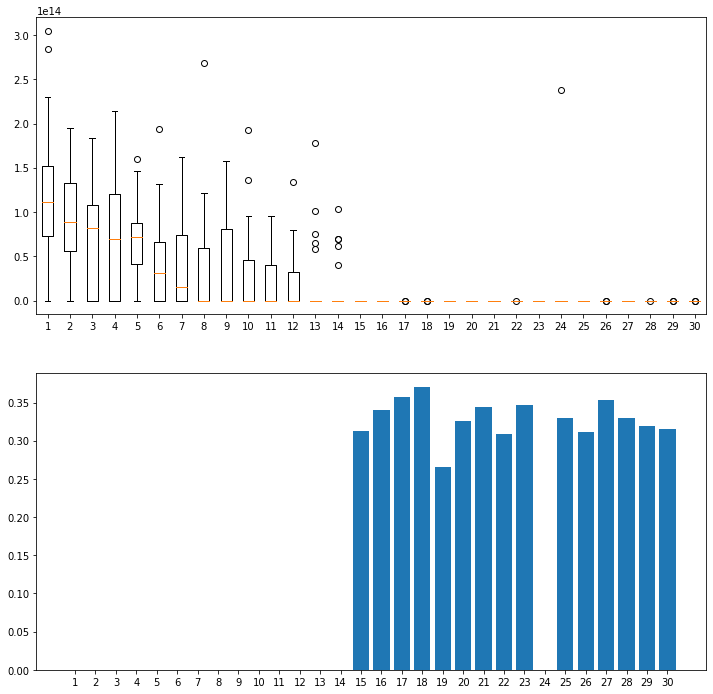

In [33]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [36]:
# pca checks result
pca = PCA(n_components = 5)
pca.fit(gse_v2)
pca_df = pca.transform(gse_v2)
approx_5 = pca.inverse_transform(pca_df)
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse_v2)
pca_df = pca.transform(gse_v2)
approx_15 = pca.inverse_transform(pca_df)
# pca checks result
pca = PCA(n_components = 10)
pca.fit(gse_v2)
pca_df = pca.transform(gse_v2)
approx_10 = pca.inverse_transform(pca_df)

Text(0.5, 1.0, 'PCA = 10')

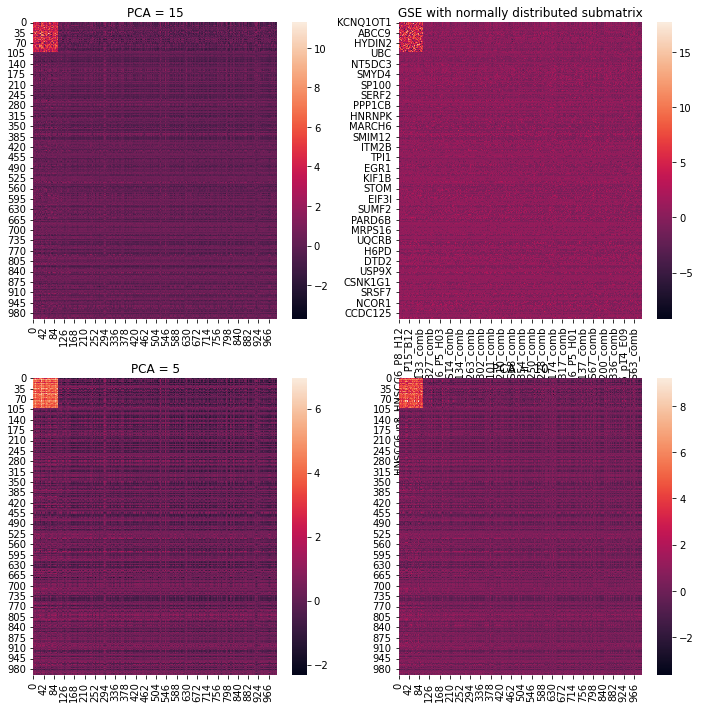

In [39]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(approx_15);
plt.title("PCA = 15")
plt.subplot(2,2,2)
sns.heatmap(gse_v2);
plt.title("GSE with normally distributed submatrix")
plt.subplot(2,2,3)
sns.heatmap(approx_5);
plt.title("PCA = 5")
plt.subplot(2,2,4)
sns.heatmap(approx_10);
plt.title("PCA = 10")

# Try Uniform Distribution

In [41]:
uni = np.random.uniform(0,10,100*100).reshape(100,100)
attach = pd.DataFrame(np.pad(uni,((0,900),(0,900)),'constant',constant_values = (0,0)), index = gse.index, columns = gse.columns)
gse_v3 = gse + attach

In [42]:
times = 30
num_comps = 30
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse_v3,times,num_comps,10,10)

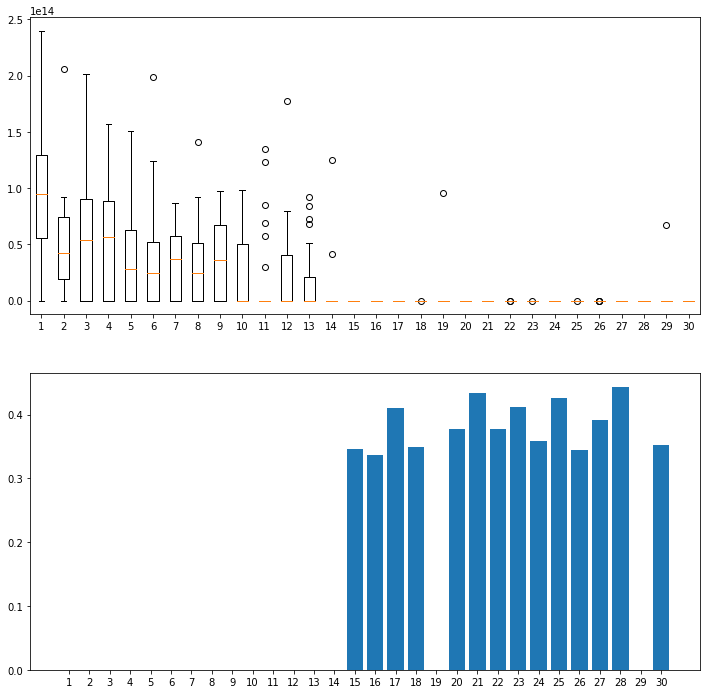

In [43]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [44]:
# pca checks result
pca = PCA(n_components = 5)
pca.fit(gse_v3)
pca_df = pca.transform(gse_v3)
approx_5 = pca.inverse_transform(pca_df)
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse_v3)
pca_df = pca.transform(gse_v3)
approx_15 = pca.inverse_transform(pca_df)
# pca checks result
pca = PCA(n_components = 10)
pca.fit(gse_v3)
pca_df = pca.transform(gse_v3)
approx_10 = pca.inverse_transform(pca_df)

Text(0.5, 1.0, 'PCA = 10')

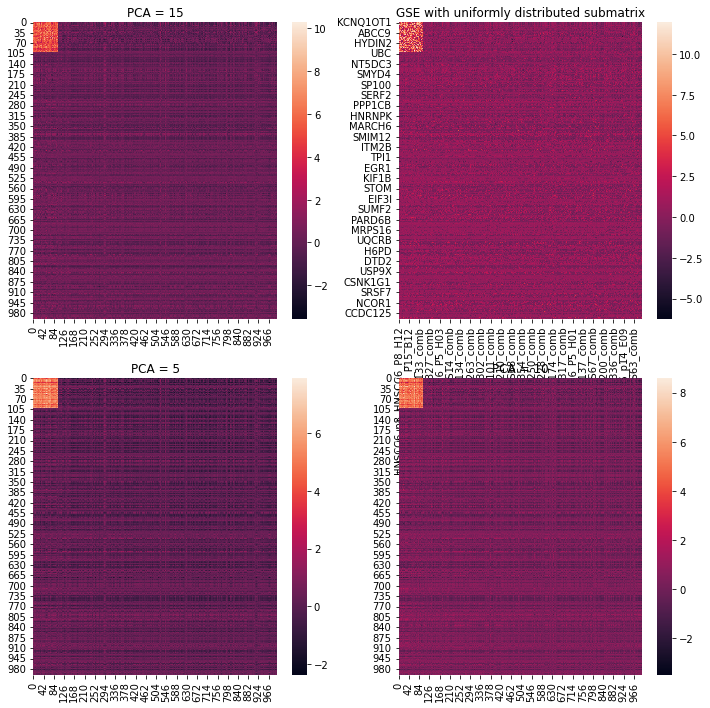

In [47]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(approx_15);
plt.title("PCA = 15")
plt.subplot(2,2,2)
sns.heatmap(gse_v3);
plt.title("GSE with uniformly distributed submatrix")
plt.subplot(2,2,3)
sns.heatmap(approx_5);
plt.title("PCA = 5")
plt.subplot(2,2,4)
sns.heatmap(approx_10);
plt.title("PCA = 10")

# Add a submatrix with only 4's and 0's

In [48]:
all4 = np.zeros((1,100))
all4.fill(4)
all0 = np.zeros((1,100))
m = all4
for i in range(99):
    if i % 2 ==0:
        m = np.concatenate((m,all0))
    else:
        m = np.concatenate((m,all4))

In [49]:
attach = pd.DataFrame(np.pad(m,((0,900),(0,900)),'constant',constant_values = (0,0)), index = gse.index, columns = gse.columns)
gse_v4 = gse + attach

In [51]:
times = 30
num_comps = 30
error_t,  q2_A = bcv(gse_v4,times,num_comps,10,10)

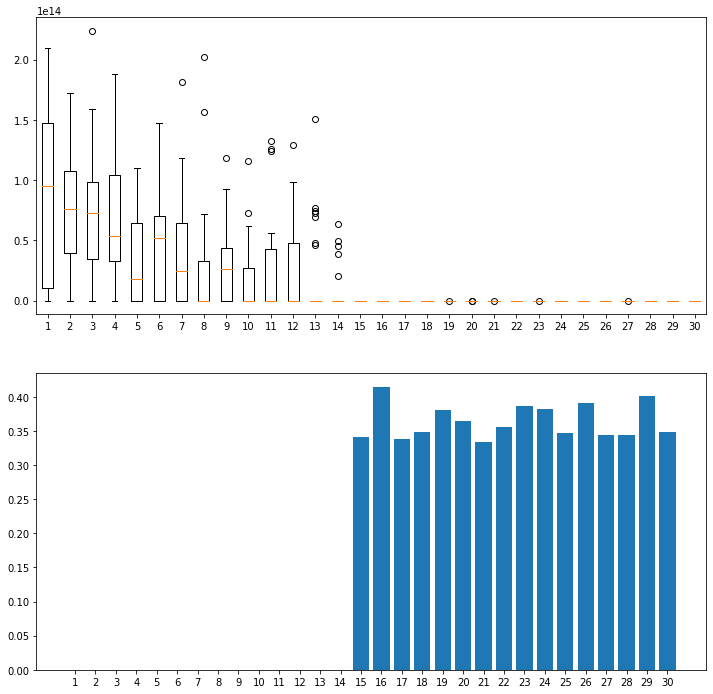

In [52]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [53]:
# pca checks result
pca = PCA(n_components = 5)
pca.fit(gse_v4)
pca_df = pca.transform(gse_v4)
approx_5 = pca.inverse_transform(pca_df)
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse_v4)
pca_df = pca.transform(gse_v4)
approx_15 = pca.inverse_transform(pca_df)
# pca checks result
pca = PCA(n_components = 10)
pca.fit(gse_v4)
pca_df = pca.transform(gse_v4)
approx_10 = pca.inverse_transform(pca_df)

Text(0.5, 1.0, 'PCA = 10')

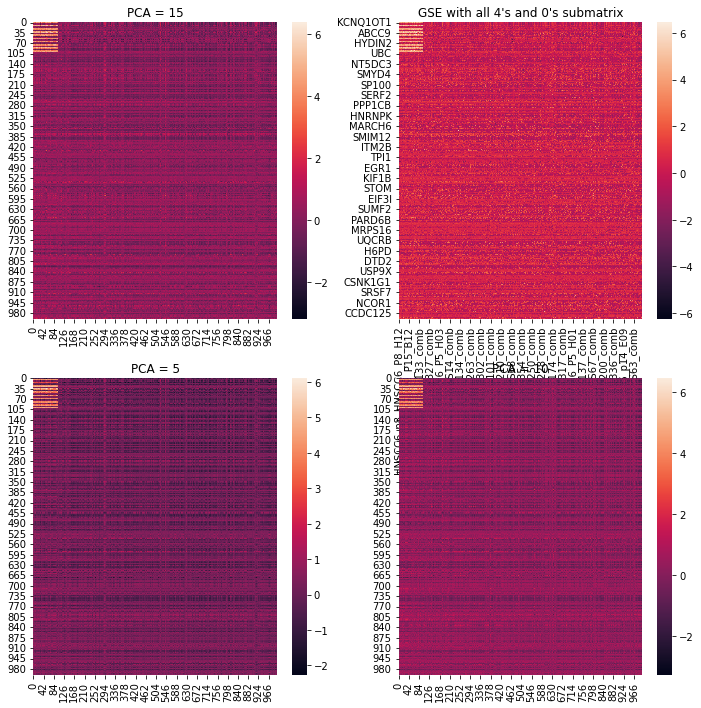

In [55]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(approx_15);
plt.title("PCA = 15")
plt.subplot(2,2,2)
sns.heatmap(gse_v4);
plt.title("GSE with all 4's and 0's submatrix")
plt.subplot(2,2,3)
sns.heatmap(approx_5);
plt.title("PCA = 5")
plt.subplot(2,2,4)
sns.heatmap(approx_10);
plt.title("PCA = 10")

# How default PCA will solve it

In [58]:
pre = data.copy()
pre[pre!=0] = 1
idx = pre.eq(1).sum(axis=1).sort_values(ascending=False).index
pre = pre.reindex(idx)
cols = pre.eq(1).sum(axis=0).sort_values(ascending=False).index
pre = pre[cols]
gse = pd.DataFrame(scale(data,axis=1), index = data.index, columns = data.columns)
gse = gse[pre.columns[0:1000]]
gse = gse.loc[pre.index[0:1000]]

Text(0, 0.5, 'explained variance ratio(%)')

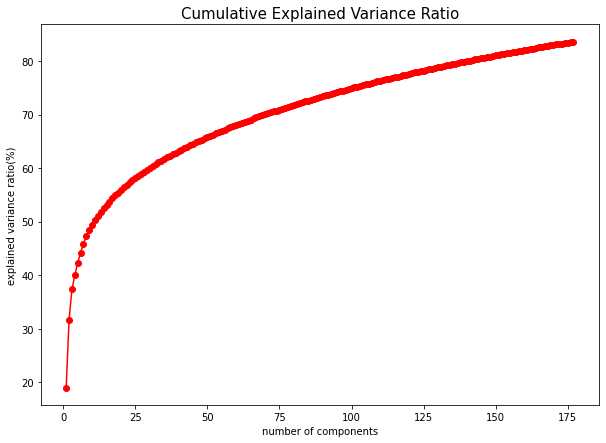

In [59]:
pca = PCA(n_components = 'mle')
pca.fit(gse)
evr = pca.explained_variance_ratio_ * 100
# 查看累计解释方差比率与主成分个数的关系
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(1, len(evr) + 1), np.cumsum(evr), "-ro")
ax.set_title("Cumulative Explained Variance Ratio", fontsize=15)
ax.set_xlabel("number of components")
ax.set_ylabel("explained variance ratio(%)")

# check svd on gse

In [60]:
u,s,vh = np.linalg.svd(gse)

In [61]:
list(s>1).count(True)

899

# check difference between 15 and 30 components

In [68]:
# pca checks result
pca = PCA(n_components = 15)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_15 = pca.inverse_transform(pca_df)

In [69]:
# pca checks result
pca = PCA(n_components = 30)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_30 = pca.inverse_transform(pca_df)

<AxesSubplot:>

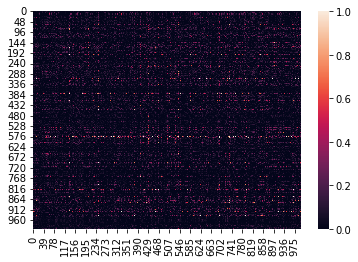

In [87]:
sns.heatmap(approx_30 - approx_15, vmin= 0, vmax = 1)

In [78]:
# pca checks result
pca = PCA(n_components = 1)
pca.fit(gse)
pca_df = pca.transform(gse)
approx_1 = pca.inverse_transform(pca_df)

<AxesSubplot:>

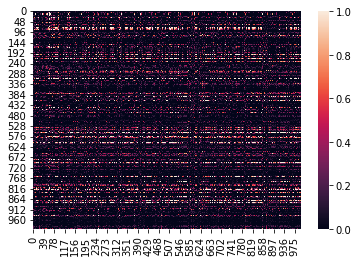

In [86]:
sns.heatmap(approx_15-approx_1, vmin= 0, vmax = 1)